## background 
- 32% survival
- women,children,upper class more likely survived
- not enough boats

## load utils

In [1]:
import sys
sys.path.append('../')
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from util import *
from onehot import LabelBinarizerEx
from pipeline import FeaturePipeline, DataFramePipeline
from binning import Binner
from title import TitleExtractor
from cabin import HasCabin
from ensemble import EnsembleStackClassifierEx
from addcols import AddColumns
from impute import GroupImputer
from alone import IsAlone

d:\app\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## load train data

In [2]:
import pandas as pd
passenger_train=pd.read_csv('train.csv')
target_col='Survived'
id_col='PassengerId'
target=passenger_train[target_col]
total_num=len(passenger_train)

### extract title from name

In [3]:
# passenger_train2=passenger_train.copy()
# passenger_train2['Title'] = passenger_train2['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
# pd.crosstab(passenger_train2['Title'], passenger_train2['Sex'])

### feature pipelines

In [4]:
passenger_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
full_pipeline=DataFramePipeline([
    FeaturePipeline('Pclass','Pclass',Pipeline([('scale',StandardScaler())])),
    FeaturePipeline('Name','Title',Pipeline([('title',TitleExtractor())])),
    FeaturePipeline('Title','',Pipeline([('onehot',LabelBinarizerEx(['Title']))])),
    FeaturePipeline('Sex','',Pipeline([('onehot',LabelBinarizerEx(['Sex']))])),
    FeaturePipeline(['Pclass','Sex','Age'],'Age_band',Pipeline([('impute',GroupImputer(['Pclass','Sex','Age'])),
                                                                ('binning',Binner([14.,35.,50.])),
                                                                ('scale',StandardScaler()),
                                              ])),
    FeaturePipeline(['SibSp','Parch'],'FamilySize',Pipeline([('addcols',AddColumns())])),
    FeaturePipeline('FamilySize','BigFamily',Pipeline([('binning',Binner([4]))])),
    FeaturePipeline('FamilySize','IsAlone',Pipeline([('alone',IsAlone())])),
    FeaturePipeline('SibSp','SibSp',Pipeline([('scale',StandardScaler())])),
    FeaturePipeline('Parch','Parch',Pipeline([('scale',StandardScaler())])),
    FeaturePipeline('FamilySize','FamilySize',Pipeline([('scale',StandardScaler())])),
    FeaturePipeline('Fare','Fare_band',Pipeline([('binning',Binner([8.,14.,31.,66.])),
                                                 ('scale',StandardScaler()),])),
    FeaturePipeline('Cabin','Cabin_has',Pipeline([('has',HasCabin())])),
    FeaturePipeline('Embarked','',Pipeline([('onehot',LabelBinarizerEx(['Embarked']))])),
])

prepared_passenger_train=full_pipeline.fit_transform(passenger_train)
# prepared_passenger_train.head()

d:\app\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\app\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\app\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\app\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\app\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warning

In [6]:
train_data=prepared_passenger_train.drop(['Survived','PassengerId','Fare','Name','Ticket','Cabin','Embarked','Title','Sex','Age'],axis=1)
# train_data.describe()

## train

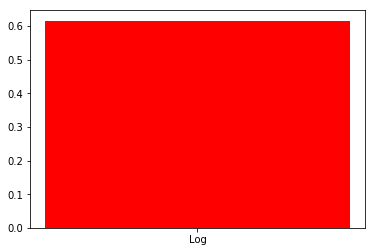

[('Log', 0.61616490890978648)]


In [7]:
from sklearn.linear_model import LogisticRegression,SGDClassifier,LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

base_clfs=[
      LogisticRegression(random_state=42,C=0.001,penalty='l1'),
#       SVC(probability=True),
#       RandomForestClassifier(random_state=0),
#       GradientBoostingClassifier(random_state=0),
#       AdaBoostClassifier(), 
#       ExtraTreesClassifier(n_jobs=-1), 
#       XGBClassifier(),
]
from sklearn.model_selection import cross_val_score

%matplotlib inline
import matplotlib.pyplot as plt
from pylab import *

def trainModels(train_data, target):
    scores=[cross_val_score(clf,train_data,target,scoring='accuracy',cv=5).mean() for clf in base_clfs]

    labels=[c.__class__.__name__[:3] for c in base_clfs]
    X=np.arange(len(base_clfs))
    bar(X,scores,tick_label=labels,color='rgb')
    show()
    print(sorted(zip(labels,scores),key=lambda x:x[1],reverse=True))
    
trainModels(train_data,target)

In [8]:
lr=LogisticRegression()
lr.fit(train_data,target)
print(lr.classes_)
p=lr.predict_proba(train_data[:3])
(p[:,0]<p[:,1]).astype('int')

[0 1]


array([0, 1, 1])

In [9]:
from aml.auto_model_machine import BinaryClassifier

bc=BinaryClassifier()
bc.fit(train_data.values,target)


[(0.82491582491582494, Counter({17: 1, 3: 1, 5: 1})), (0.82491582491582494, Counter({5: 2, 19: 1, 3: 1})), (0.82154882154882158, Counter({13: 1, 5: 1})), (0.81818181818181823, Counter({3: 3, 9: 2, 5: 1, 8: 1, 2: 1, 12: 1, 13: 1})), (0.81818181818181823, Counter({5: 2, 10: 1, 3: 1, 13: 1, 9: 1}))]


BinaryClassifier()